# Experiment Ten

## Processing

In [20]:
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [21]:
# Analytical Tools
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# General Utilities
import itertools
import json
import pprint

# Custom Utilities
import utilities.processing as processing
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

### Reading Data and Defining Constants

In [22]:
FILE_NAMES = [
    'raw-data/survey-ten-responses.json',
]

NUM_JUDGEMENTS = 1
NUMBER_OF_GROUPS = 2
GROUP_SIZE = 2
ALL_LABELS = processing.get_article_labels(
    NUMBER_OF_GROUPS,
    GROUP_SIZE
)
JUDGMENT_LABELS = processing.get_judgment_labels(NUM_JUDGEMENTS)

master_responses = []
for name in FILE_NAMES:
    with open(name) as file:
        master_responses.extend(json.loads(line) for line in file if line)

In [23]:
master_responses[30]

{'__v': 0,
 '_id': {'$oid': '5b08b53edd91620004392831'},
 'data': {'conditionNumber': 1,
  'groupNumber': 1,
  'participantID': 'ne4b0fgkk9l0pylv46j880p926rzl8f0',
  'responseType': 1}}

### Reading Responses into Data

In [24]:
col_labels = processing.get_col_labels(
    NUMBER_OF_GROUPS,
    GROUP_SIZE,
    NUM_JUDGEMENTS)
data = {label: [] for label in col_labels}

In [25]:
processing.fill_experiment_data(data, master_responses)

In [26]:
data = pd.DataFrame(data)
sample_size = len(data)
print(data.size, sample_size)

2850 150


In [27]:
view_data = data[data.response_type == 1]
response_data = data[data.response_type == 0]
response_data = response_data[response_data.consent == 1]

print(len(view_data), len(response_data))
print('{:.4}% completion'.format(len(response_data) / len(view_data) * 100))

79 71
89.87% completion


### Seperating Groups and Checking Response Rate

In [28]:
quiz_views = view_data[view_data.condition_number == 0]
upvote_views = view_data[view_data.condition_number == 1]
quiz_responses = response_data[response_data.condition_number == 0]
upvote_responses = response_data[response_data.condition_number == 1]

print(len(quiz_views), len(upvote_views))
print(len(quiz_responses), len(upvote_responses))

40 39
36 35


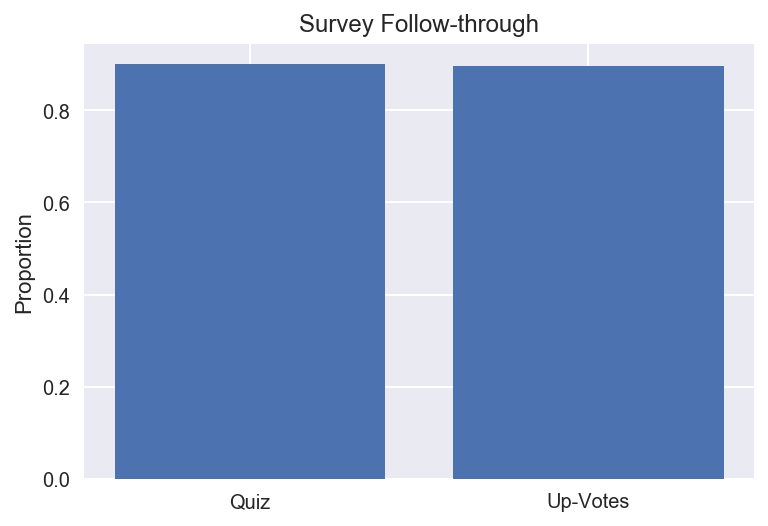

In [29]:
PLOTTING_OPTIONS = {
    'ylabel': 'Proportion',
    'ticks': ['Quiz', 'Up-Votes'],
    'title': 'Survey Follow-through',
}

plotting.plot_single_bar(
    [len(quiz_responses) / len(quiz_views),
     len(upvote_responses) / len(upvote_views)],
    **PLOTTING_OPTIONS
)

### Checking Quiz Results

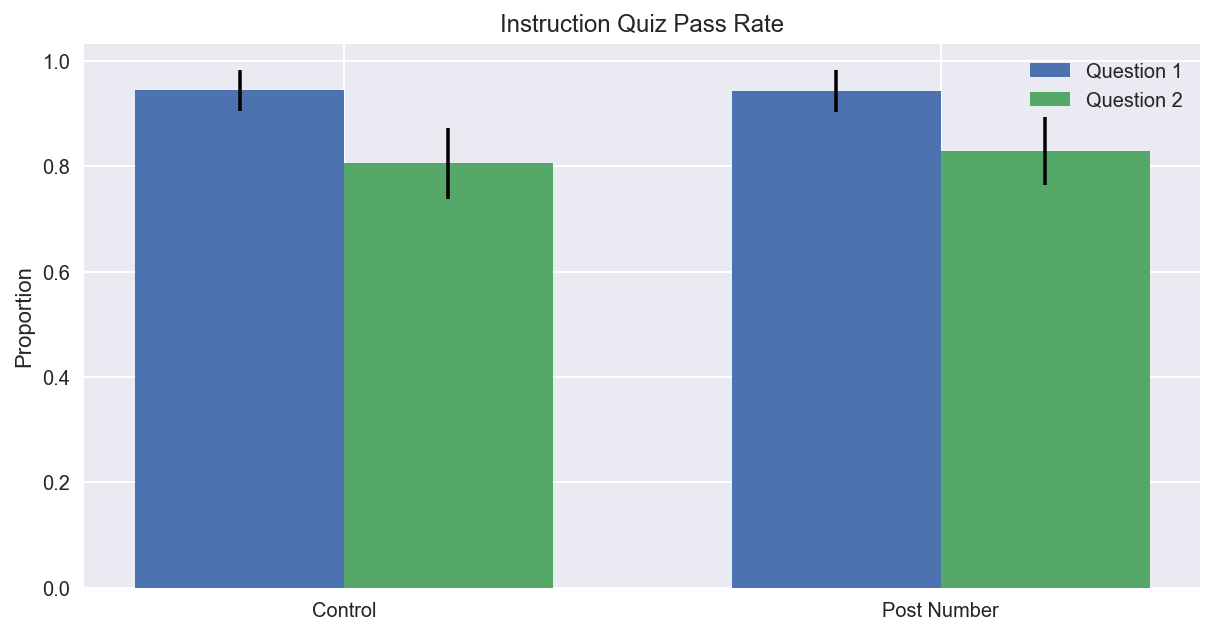

In [30]:
PLOTTING_OPTIONS = {
    'ylabel': 'Proportion',
    'ticks': ['Control', 'Post Number', 'Up-Votes'],
    'legend': ['Question 1', 'Question 2'],
    'title': 'Instruction Quiz Pass Rate',
    'size': (10, 5)
}

one_means, one_errs = [], []
two_means, two_errs = [], []
for group in (quiz_responses, upvote_responses):
    one_means.append(group.quiz_one.mean())
    one_errs.append(stats.sem(group.quiz_one))
    two_means.append(group.quiz_two.mean())
    two_errs.append(stats.sem(group.quiz_two))

plotting.plot_double_bar(one_means, one_errs, two_means,
                         two_errs, **PLOTTING_OPTIONS)


In [31]:
new_quiz_responses = quiz_responses[
    (quiz_responses.quiz_one == 1)
    & (quiz_responses.quiz_two == 1)]
new_upvote_responses = upvote_responses[
    (upvote_responses.quiz_one == 1) 
    & (upvote_responses.quiz_two == 1)]


quiz_removed = len(quiz_responses) - len(new_quiz_responses)
upvote_removed = len(upvote_responses) - len(new_upvote_responses)

print('Control: {} removed ({:.3}%) {} left'.format(
    quiz_removed,
    quiz_removed / len(quiz_responses) * 100,
    len(new_quiz_responses)
))
print('Upvote: {} removed ({:.3}%) {} left'.format(
    upvote_removed,
    upvote_removed / len(new_upvote_responses) * 100,
    len(new_upvote_responses)
))

Control: 8 removed (22.2%) 28 left
Upvote: 7 removed (25.0%) 28 left


### Naive Variance Analaysis

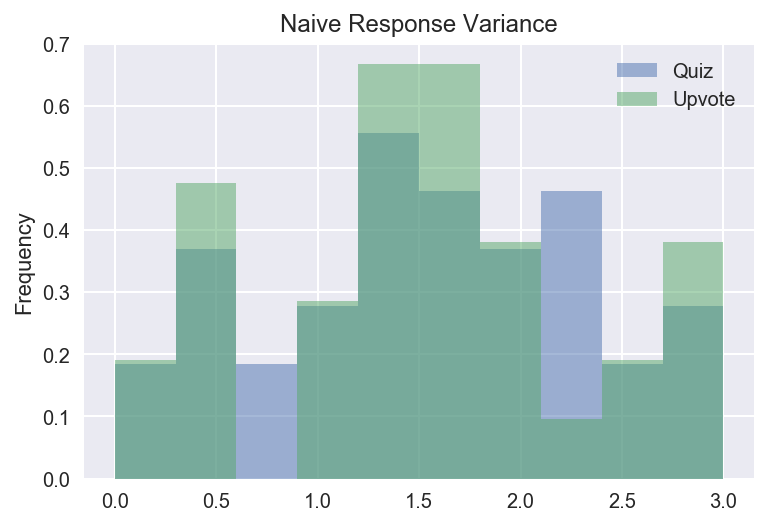

In [32]:
PLOTTING_OPTIONS = {
    'title': 'Naive Response Variance',
    'ylabel': 'Frequency',
    'legend': ['Quiz', 'Upvote']
}

for data in (quiz_responses, upvote_responses):
    all_judgment_headers = ['{}_{}'.format(q_label, j_label) for 
                            q_label, j_label in itertools.product(
                                ALL_LABELS, JUDGMENT_LABELS)]
    data.total_var = data[all_judgment_headers].std(axis=1)
    plt.hist(data.total_var, alpha=0.5, normed=1)

plotting.label_graph(**PLOTTING_OPTIONS)
plt.show()

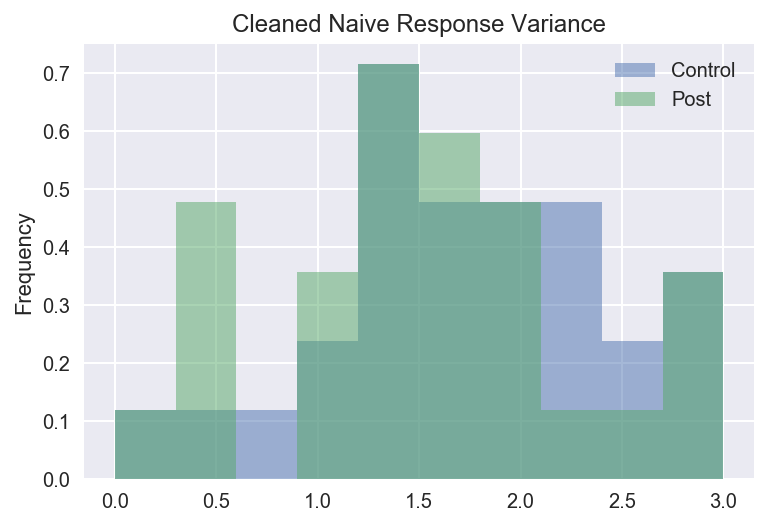

In [33]:
PLOTTING_OPTIONS = {
    'title': 'Cleaned Naive Response Variance',
    'ylabel': 'Frequency',
    'legend': ['Control', 'Post', 'Upvote']
}

for data in (new_quiz_responses, new_upvote_responses):
    all_judgment_headers = ['{}_{}'.format(q_label, j_label) for 
                            q_label, j_label in itertools.product(
                                ALL_LABELS, JUDGMENT_LABELS)]
    data.total_var = data[all_judgment_headers].std(axis=1)
    plt.hist(data.total_var, alpha=0.5, normed=1)

plotting.label_graph(**PLOTTING_OPTIONS)
plt.show()

### Saving Data

In [34]:
new_quiz_responses.to_pickle('raw-data/quiz-responses.pkl')
new_upvote_responses.to_pickle('raw-data/upvote-responses.pkl')